In [2]:
pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB 660.6 kB/s eta 0:00:15
   ----- ---------------------------------- 1.2/9.9 MB 15.8 MB/s eta 0:00:01
   ------------ --------------------------- 3.2/9.9 MB 22.5 MB/s eta 0:00:01
   ------------------- -------------------- 4.9/9.9 MB 28.5 MB/s eta 0:00:01
   ---------------------------- ----------- 6.9/9.9 MB 29.5 MB/s eta 0:00:01
   ----------------------------------- ---- 8.6/9.9 MB 32.5 MB/s eta 0:00:01
   ---------------------------------------  9.9/9.9 MB 31.4 MB/s eta 0:00:01
   ---------------------------------------  9.9/9.9 MB 31.4 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 25.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   --------------------------------------- 233.9/233.9 kB 14.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [4]:
# Load the dataset
try:
  df = pd.read_csv(r'C:\Users\vidha\Downloads\Algerian_forest_fires_cleaned.csv')
except FileNotFoundError:
  print("Error: File not found. Please check the file path.")
  exit()

# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())



   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2  1.2  3.9   

   FWI      Classes  Region  
0  0.5  not fire          0  
1  0.4  not fire          0  
2  0.1  not fire          0  
3  0.0  not fire          0  
4  0.5  not fire          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

if missing_values.sum() > 0:
  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
  print("Missing values imputed.")
else:
  df_imputed = df.copy()

# Check for duplicate rows
duplicate_rows = df_imputed.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")
if duplicate_rows > 0:
  df_imputed = df_imputed.drop_duplicates()
  print("Duplicate rows removed.")

# Convert 'Classes' to numerical values
try:
  df_imputed['Classes'] = df_imputed['Classes'].str.strip().map({'fire': 1, 'not fire': 0})
except AttributeError:
  print("Error: 'Classes' column not found or not in expected format.")
  exit()

# Create a datetime column
try:
  df_imputed['date'] = pd.to_datetime(df_imputed[['year', 'month', 'day']])
except KeyError:
  print("Error: One or more of 'year', 'month', 'day' columns not found.")
  exit()



Missing values:
 day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64
Number of duplicate rows: 0


Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations       
Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42      
RH : Relative Humidity in %: 21 to 90       
Ws :Wind speed in km/h: 6 to 29     
Rain: total day in mm: 0 to 16.8 FWI Components     
Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5      
Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9     
Drought Code (DC) index from the FWI system: 7 to 220.4     
Initial Spread Index (ISI) index from the FWI system: 0 to 18.5     
Buildup Index (BUI) index from the FWI system: 1.1 to 68        
Fire Weather Index (FWI) Index: 0 to 31.1       
Classes: two classes, namely Fire and not Fire      

We have data from two different regions : Bejaia Region and Sidi-Bel Abbes Region

In [6]:
# Drop unnecessary columns
df_imputed.drop(['day', 'month', 'year'], axis=1, inplace=True)

# Apply filters based on the guidelines
df_filtered = df_imputed[
  (df_imputed['Temperature'].between(22, 42)) &
  (df_imputed['RH'].between(21, 90)) &
  (df_imputed['Ws'].between(6, 29)) &
  (df_imputed['Rain'].between(0, 16.8)) &
  (df_imputed['FFMC'].between(28.6, 92.5)) &
  (df_imputed['DMC'].between(1.1, 65.9)) &
  (df_imputed['DC'].between(7, 220.4)) &
  (df_imputed['ISI'].between(0, 18.5)) &
  (df_imputed['BUI'].between(1.1, 68)) &
  (df_imputed['FWI'].between(0, 31.1))
]

# Display summary statistics
print(df_filtered.describe())



       Temperature          RH          Ws        Rain        FFMC  \
count   229.000000  229.000000  229.000000  229.000000  229.000000   
mean     32.030568   62.973799   15.532751    0.750655   77.901310   
min      22.000000   33.000000    6.000000    0.000000   36.100000   
25%      30.000000   54.000000   14.000000    0.000000   72.300000   
50%      32.000000   64.000000   15.000000    0.000000   82.700000   
75%      35.000000   73.000000   17.000000    0.500000   87.800000   
max      40.000000   90.000000   29.000000   16.800000   92.500000   
std       3.351346   13.387255    2.840037    1.958934   13.247851   

              DMC          DC         ISI         BUI         FWI     Classes  \
count  229.000000  229.000000  229.000000  229.000000  229.000000  229.000000   
mean    14.503057   49.968559    4.322707   16.625764    6.563755    0.554585   
min      1.100000    7.000000    0.000000    1.600000    0.000000    0.000000   
25%      5.800000   14.200000    1.400000    

In [7]:
#Selecting numerical columns

numerical_cols = df_filtered.select_dtypes(include=[np.number]).columns

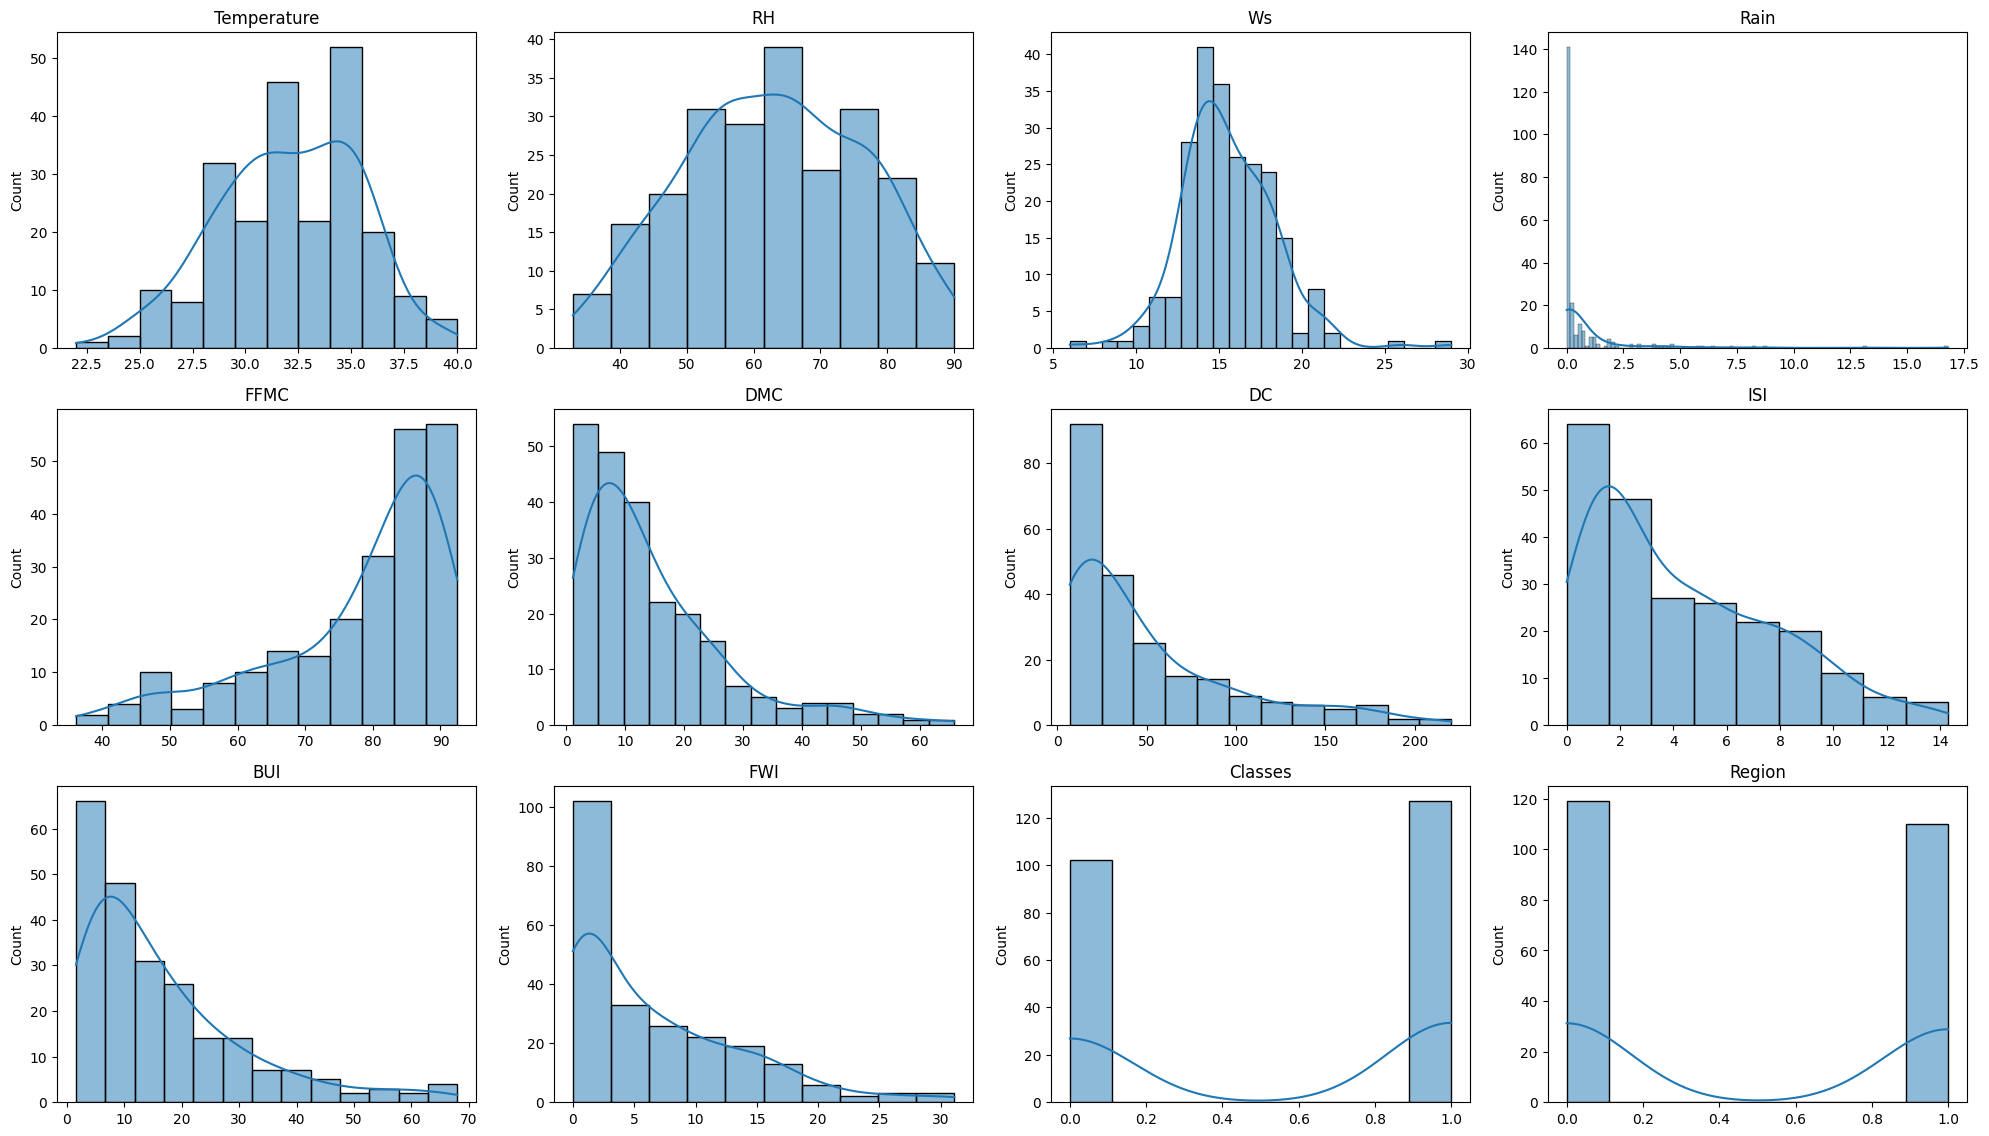

In [8]:
# Visualizations
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
  plt.subplot(4, 4, i)
  sns.histplot(df_filtered[col], kde=True)
  plt.title(col)
  plt.xlabel('')
plt.tight_layout()
plt.show()


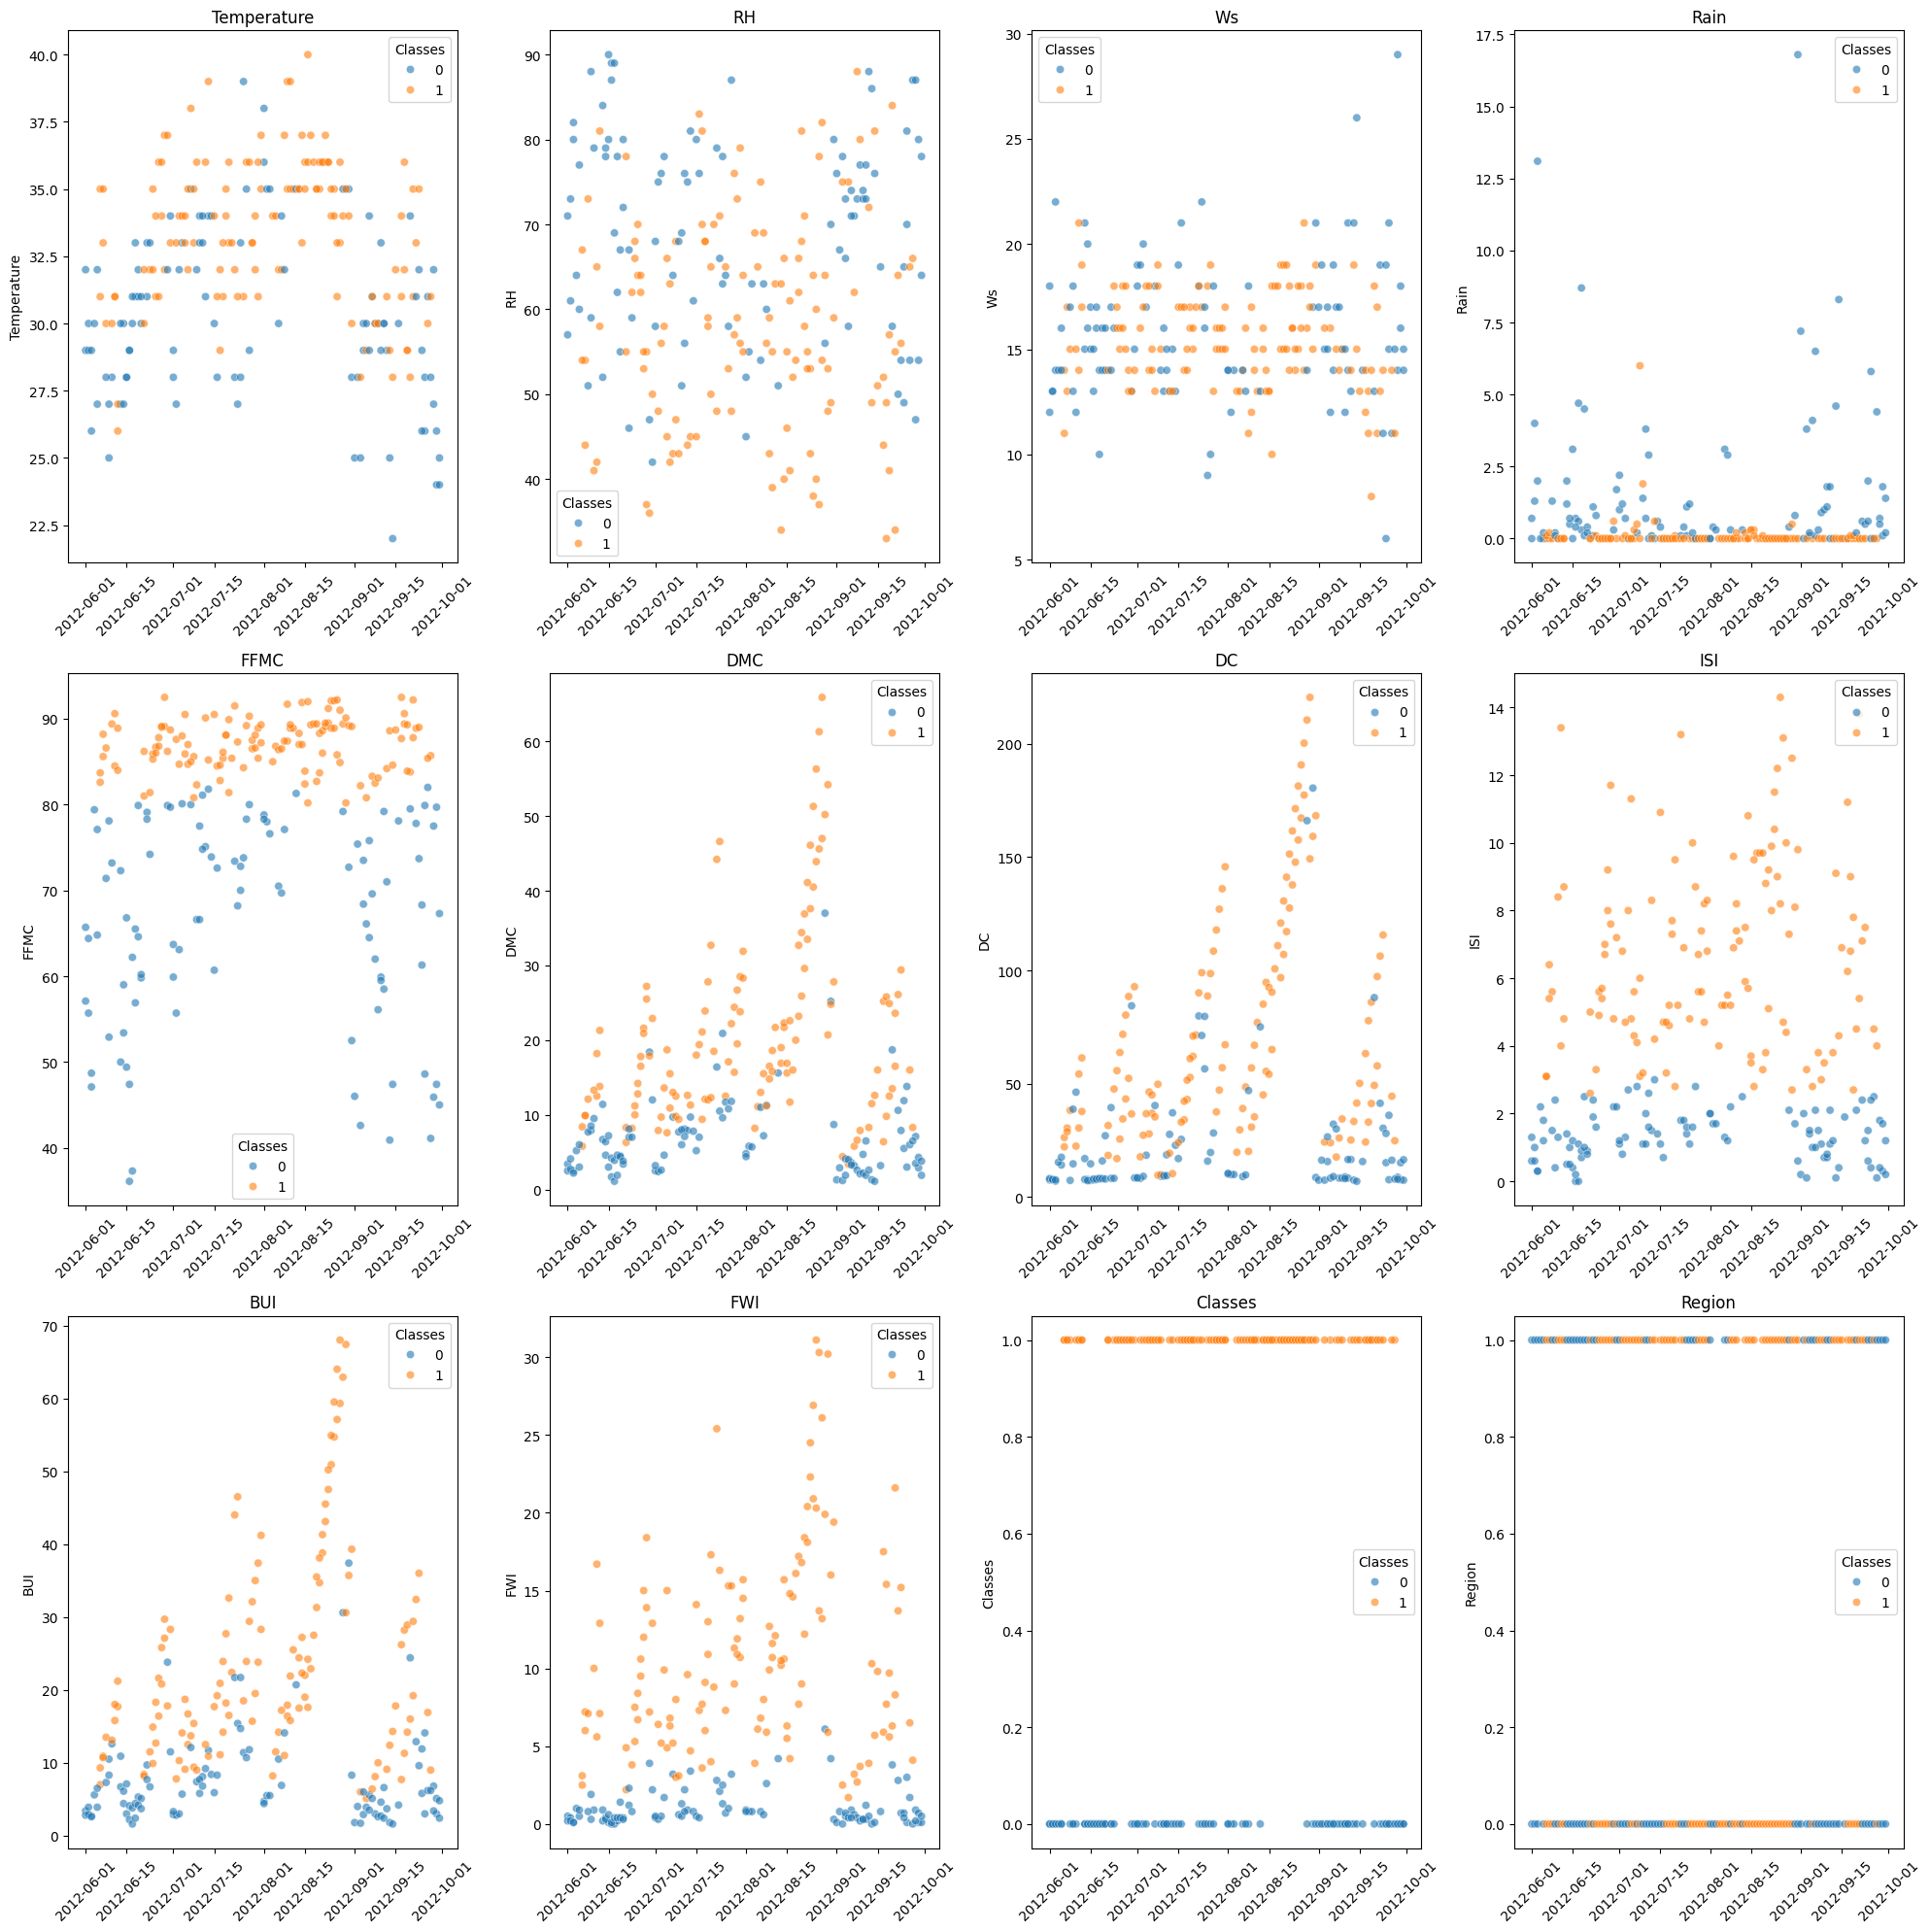

In [9]:
# Scatter plots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
  sns.scatterplot(data=df_filtered, x='date', y=col, hue='Classes', ax=axes[i], alpha=0.6)
  axes[i].set_title(col)
  axes[i].set_xlabel('')
  axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



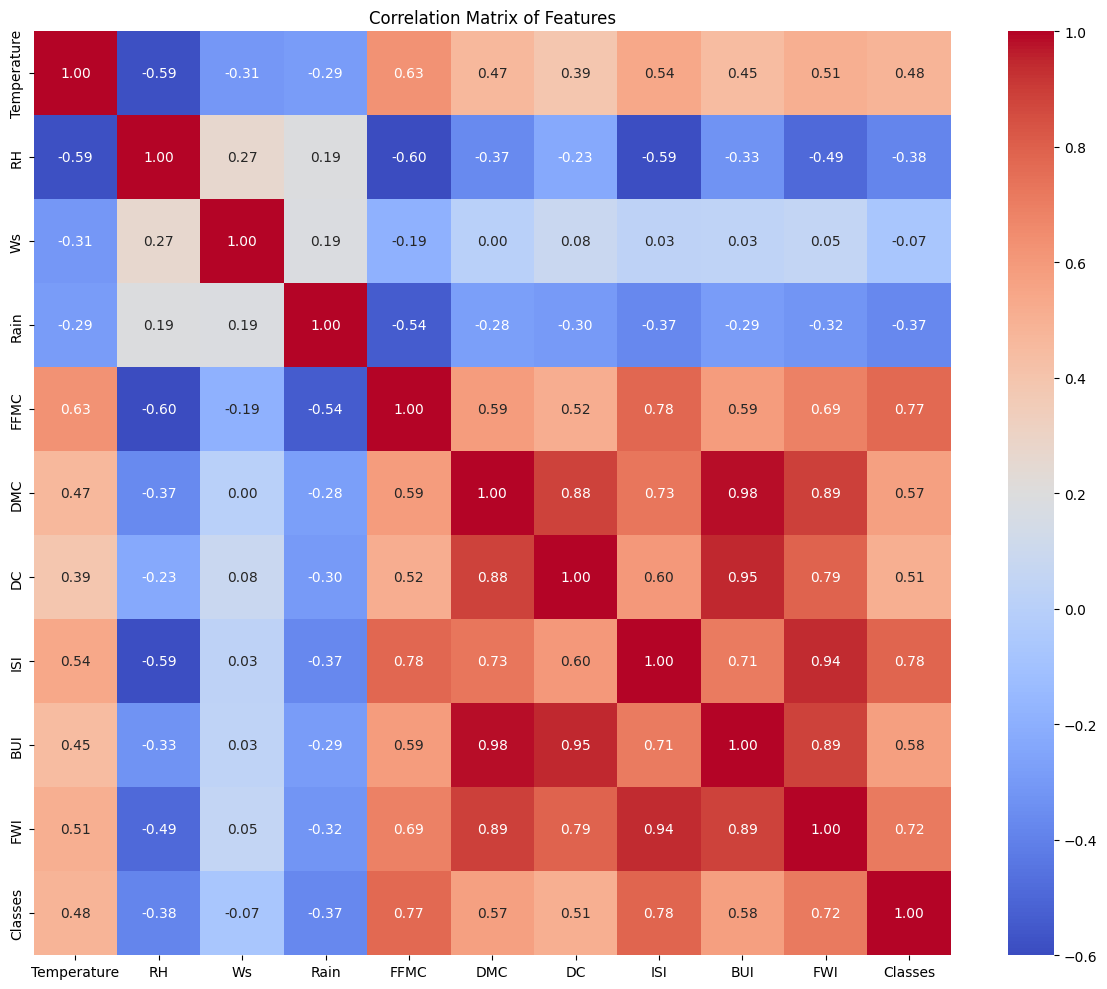

In [10]:
# Correlation matrix
correlation_matrix = df_filtered.drop(['date', 'Region'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()



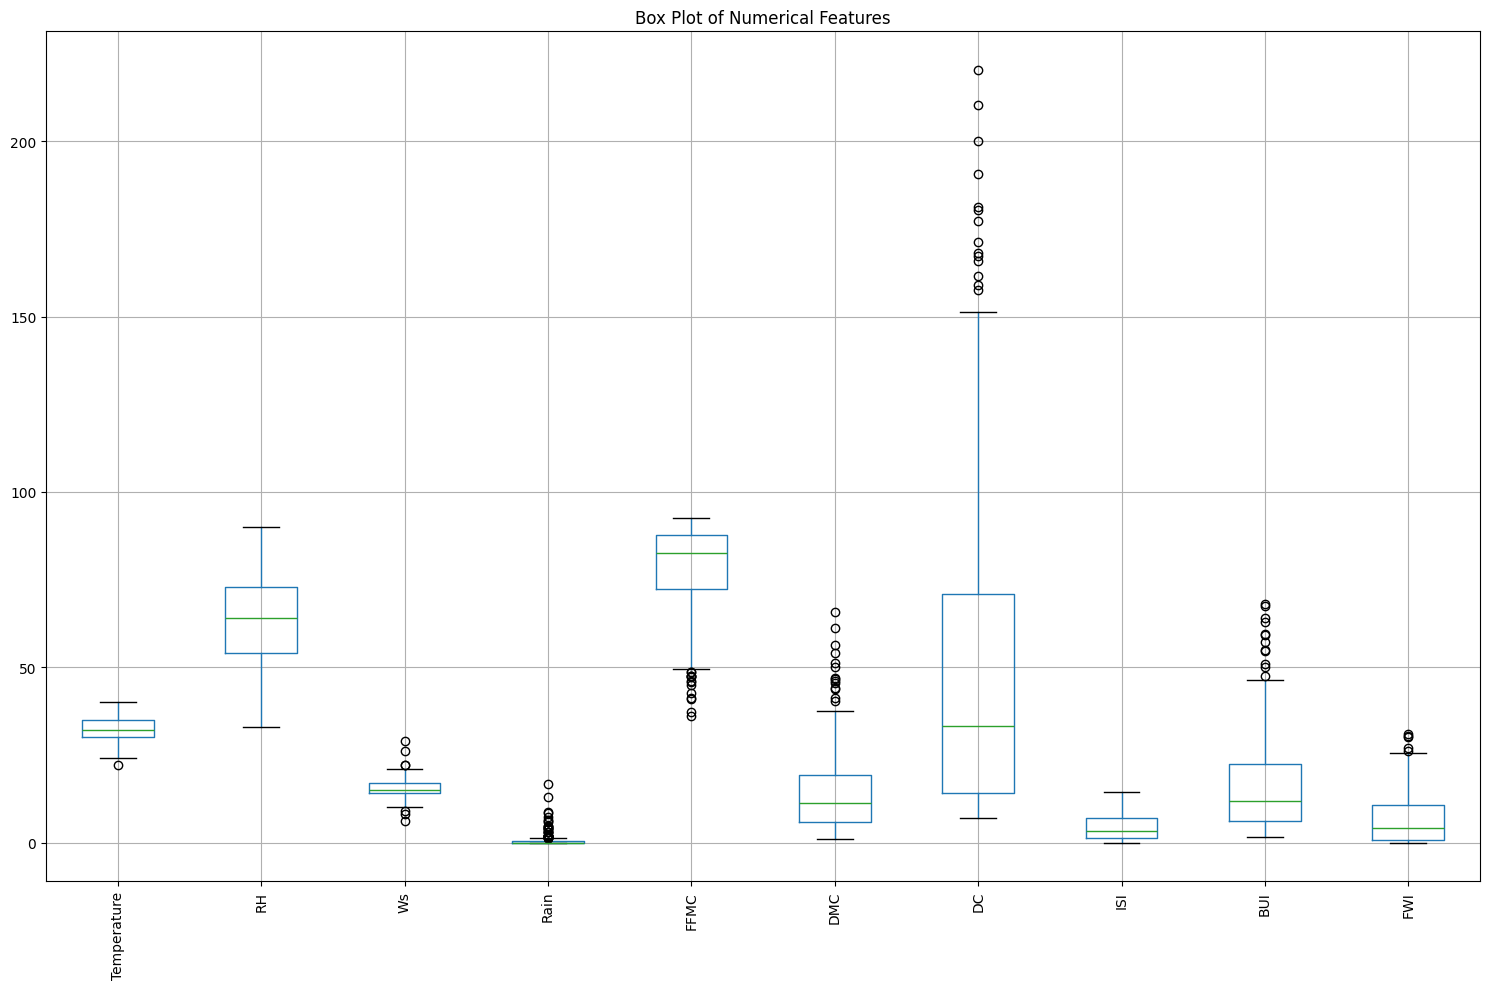

In [11]:
# Box plots
plt.figure(figsize=(15, 10))
df_filtered.drop(['date', 'Classes', 'Region'], axis=1).boxplot(rot=90)
plt.title('Box Plot of Numerical Features')
plt.tight_layout()
plt.show()



In [12]:
print("\n Class Distribution:")
class_distribution = df_filtered['Classes'].value_counts(normalize=True)
print(class_distribution)
if abs(class_distribution[0] - class_distribution[1]) > 0.2:
  print("   The classes are imbalanced. Consider using techniques to address this in modeling.")

print("\n Temporal Patterns:")
monthly_fire_rate = df_filtered.groupby(df_filtered['date'].dt.month)['Classes'].mean()
print("   Monthly fire rates:")
print(monthly_fire_rate)






 Class Distribution:
Classes
1    0.554585
0    0.445415
Name: proportion, dtype: float64

 Temporal Patterns:
   Monthly fire rates:
date
6    0.423729
7    0.616667
8    0.796296
9    0.392857
Name: Classes, dtype: float64


In [13]:
print("\n2. Correlation Analysis:")
high_correlations = correlation_matrix.where(np.abs(correlation_matrix) > 0.7).stack().reset_index()
high_correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlations = high_correlations[high_correlations['Feature 1'] != high_correlations['Feature 2']]
print(high_correlations)


2. Correlation Analysis:
   Feature 1 Feature 2  Correlation
5       FFMC       ISI     0.779538
6       FFMC   Classes     0.773958
8        DMC        DC     0.883225
9        DMC       ISI     0.725763
10       DMC       BUI     0.982744
11       DMC       FWI     0.891995
12        DC       DMC     0.883225
14        DC       BUI     0.945633
15        DC       FWI     0.790546
16       ISI      FFMC     0.779538
17       ISI       DMC     0.725763
19       ISI       BUI     0.709908
20       ISI       FWI     0.941693
21       ISI   Classes     0.781589
22       BUI       DMC     0.982744
23       BUI        DC     0.945633
24       BUI       ISI     0.709908
26       BUI       FWI     0.886847
27       FWI       DMC     0.891995
28       FWI        DC     0.790546
29       FWI       ISI     0.941693
30       FWI       BUI     0.886847
32       FWI   Classes     0.717836
33   Classes      FFMC     0.773958
34   Classes       ISI     0.781589
35   Classes       FWI     0.717836


In [15]:
def calculate_vif(X):
  vif_data = pd.DataFrame()
  vif_data["Feature"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return vif_data.sort_values("VIF", ascending=False)

# Assuming df_filtered is your dataframe after all the preprocessing steps
X = df_filtered.drop(['date', 'Classes', 'Region'], axis=1)

In [16]:
def iterative_vif_elimination(X, threshold=10):
  features = X.columns.tolist()
  dropped_features = []
  
  while True:
      vif_data = calculate_vif(X)
      max_vif = vif_data["VIF"].max()
      
      if max_vif > threshold:
          feature_to_drop = vif_data.loc[vif_data["VIF"] == max_vif, "Feature"].iloc[0]
          features.remove(feature_to_drop)
          dropped_features.append(feature_to_drop)
          X = X.drop(feature_to_drop, axis=1)
          print(f"Dropped {feature_to_drop} with VIF {max_vif:.2f}")
      else:
          break
  
  return X, dropped_features

In [17]:
X_reduced, dropped_features = iterative_vif_elimination(X)

print("\nDropped features:")
for i, feature in enumerate(dropped_features, 1):
  print(f"{i}. {feature}")

print("\nFinal VIF scores:")
final_vif = calculate_vif(X_reduced)
print(final_vif)

Dropped BUI with VIF 416.80
Dropped FWI with VIF 206.60
Dropped FFMC with VIF 111.70
Dropped Ws with VIF 34.47
Dropped Temperature with VIF 29.98
Dropped DMC with VIF 14.96

Dropped features:
1. BUI
2. FWI
3. FFMC
4. Ws
5. Temperature
6. DMC

Final VIF scores:
  Feature       VIF
3     ISI  3.565364
2      DC  3.348724
0      RH  2.654534
1    Rain  1.313133


In [18]:
df_filtered

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region,date
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0,2012-06-01
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0,2012-06-02
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0,2012-06-03
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0,2012-06-05
5,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,1,0,2012-06-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,1,2012-09-26
239,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0,1,2012-09-27
240,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0,1,2012-09-28
241,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0,1,2012-09-29


In [19]:
# List of features to drop based on VIF analysis
features_to_drop = ['BUI', 'FWI', 'FFMC', 'Ws', 'Temperature', 'DMC']

# Create new dataframe df_vif by dropping the specified columns
df_vif = df_filtered.drop(columns=features_to_drop)

<Axes: >

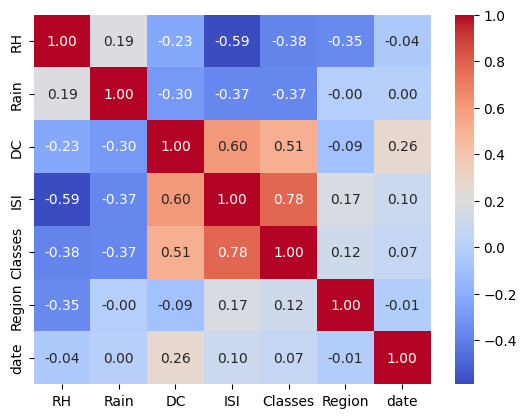

In [20]:
sns.heatmap(df_vif.corr(), annot=True, cmap='coolwarm', fmt='.2f')

## 5. Model Development and Analysis (1.5 Marks)
0.5 marks: Implementation of multiple linear regression and polynomial regression models.       
0.5 marks: Application of regularization techniques (Lasso, Ridge, elastic net).        
0.5 marks: Effective use of cross-validation and hyperparameter tuning.     

## 4. Model Evaluation and Testing (1 Mark)     
0.5 marks: Comprehensive evaluation of model performance using appropriate metrics.     
0.5 marks: Testing the model on unseen data and providing a thorough analysis of results.       



In [21]:
# Define features (X) and target variable (y)
X = df_vif[['RH', 'Rain', 'DC', 'ISI']]
y = df_vif['Classes']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base Models
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
y_pred_mlr = mlr_model.predict(X_test)

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(poly_features.transform(X_test))

# Hyperparameter Tuning Space
param_grid_mlr_ridge = {'alpha': [0.01, 0.1, 1, 10]}
param_grid_mlr_lasso = {'alpha': [0.01, 0.1, 1, 10]}
param_grid_mlr_elastic_net = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
param_grid_poly_ridge = {'alpha': [0.01, 0.1, 1, 10]}
param_grid_poly_lasso = {'alpha': [0.01, 0.1, 1, 10]}
param_grid_poly_elastic_net = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}

# Perform GridSearchCV for Hyperparameter Tuning
mlr_ridge_grid = GridSearchCV(Ridge(), param_grid_mlr_ridge, cv=5)
mlr_ridge_grid.fit(X_train, y_train)
y_pred_mlr_ridge = mlr_ridge_grid.predict(X_test)

mlr_lasso_grid = GridSearchCV(Lasso(), param_grid_mlr_lasso, cv=5)
mlr_lasso_grid.fit(X_train, y_train)
y_pred_mlr_lasso = mlr_lasso_grid.predict(X_test)

mlr_elastic_net_grid = GridSearchCV(ElasticNet(), param_grid_mlr_elastic_net, cv=5)
mlr_elastic_net_grid.fit(X_train, y_train)
y_pred_mlr_elastic_net = mlr_elastic_net_grid.predict(X_test)

poly_ridge_grid = GridSearchCV(Ridge(), param_grid_poly_ridge, cv=5)
poly_ridge_grid.fit(X_train_poly, y_train)
y_pred_poly_ridge = poly_ridge_grid.predict(poly_features.transform(X_test))

poly_lasso_grid = GridSearchCV(Lasso(), param_grid_poly_lasso, cv=5)
poly_lasso_grid.fit(X_train_poly, y_train)
y_pred_poly_lasso = poly_lasso_grid.predict(poly_features.transform(X_test))

poly_elastic_net_grid = GridSearchCV(ElasticNet(), param_grid_poly_elastic_net, cv=5)
poly_elastic_net_grid.fit(X_train_poly, y_train)
y_pred_poly_elastic_net = poly_elastic_net_grid.predict(poly_features.transform(X_test))

# Perform Cross-Validation
scores_mlr_ridge = cross_val_score(Ridge(alpha=mlr_ridge_grid.best_params_['alpha']), X_train, y_train, cv=5)
scores_mlr_lasso = cross_val_score(Lasso(alpha=mlr_lasso_grid.best_params_['alpha']), X_train, y_train, cv=5)
scores_mlr_elastic_net = cross_val_score(ElasticNet(alpha=mlr_elastic_net_grid.best_params_['alpha'], l1_ratio=mlr_elastic_net_grid.best_params_['l1_ratio']), X_train, y_train, cv=5)

scores_poly_ridge = cross_val_score(Ridge(alpha=poly_ridge_grid.best_params_['alpha']), X_train_poly, y_train, cv=5)
scores_poly_lasso = cross_val_score(Lasso(alpha=poly_lasso_grid.best_params_['alpha']), X_train_poly, y_train, cv=5)
scores_poly_elastic_net = cross_val_score(ElasticNet(alpha=poly_elastic_net_grid.best_params_['alpha'], l1_ratio=poly_elastic_net_grid.best_params_['l1_ratio']), X_train_poly, y_train, cv=5)

# Model Evaluation
models = {
    'Multiple Linear Regression': y_pred_mlr,
    'Polynomial Regression': y_pred_poly,
    'MLR-Ridge': y_pred_mlr_ridge,
    'MLR-Lasso': y_pred_mlr_lasso,
    'MLR-ElasticNet': y_pred_mlr_elastic_net,
    'PR-Ridge': y_pred_poly_ridge,
    'PR-Lasso': y_pred_poly_lasso,
    'PR-ElasticNet': y_pred_poly_elastic_net
}

metrics = ['MSE', 'R2 Score', 'MAE']
results = []

for model_name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append([model_name, mse, r2, mae])


# Create a new DataFrame to store the results with hyperparameter tuning
results_tuned_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'MSE', 'R2 Score', 'MAE'])

models_tuned = {
    'MLR-Ridge': (mlr_ridge_grid, X_test),  
    'MLR-Lasso': (mlr_lasso_grid, X_test),
    'MLR-ElasticNet': (mlr_elastic_net_grid, X_test),
    'PR-Ridge': (poly_ridge_grid, poly_features.transform(X_test)),  
    'PR-Lasso': (poly_lasso_grid, poly_features.transform(X_test)),
    'PR-ElasticNet': (poly_elastic_net_grid, poly_features.transform(X_test))
}

for model_name, (grid, X_test_transformed) in models_tuned.items():
    y_pred = grid.predict(X_test_transformed)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    best_params = grid.best_params_
    
    results_tuned_df = pd.concat([results_tuned_df, 
                                  pd.DataFrame([[model_name, str(best_params), mse, r2, mae]], 
                                               columns=['Model', 'Best Parameters', 'MSE', 'R2 Score', 'MAE'])])

                            

c:\Users\vidha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+00, tolerance: 3.639e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\vidha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e+00, tolerance: 3.582e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\vidha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [22]:
# Print Cross-Validation Scores
print("Cross-Validation Scores:")
print("MLR-Ridge:", scores_mlr_ridge)
print("MLR-Lasso:", scores_mlr_lasso)
print("MLR-ElasticNet:", scores_mlr_elastic_net)
print("PR-Ridge:", scores_poly_ridge)
print("PR-Lasso:", scores_poly_lasso)
print("PR-ElasticNet:", scores_poly_elastic_net)

Cross-Validation Scores:
MLR-Ridge: [0.61146157 0.70385616 0.58227379 0.65042664 0.47841328]
MLR-Lasso: [0.6105236  0.70488832 0.58428967 0.64805821 0.47836152]
MLR-ElasticNet: [0.6106768  0.70051666 0.58223871 0.64128478 0.49198352]
PR-Ridge: [0.80353615 0.83049    0.71051764 0.85381625 0.7176009 ]
PR-Lasso: [0.78786291 0.83002245 0.66868754 0.84417061 0.73131756]
PR-ElasticNet: [0.79929483 0.81487614 0.69166301 0.85168888 0.72680848]


In [23]:
# Display results in a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R2 Score', 'MAE'])
print("\nModel Performance:")
results_df


Model Performance:


,Model,MSE,R2 Score,MAE
0,Multiple Linear Regression,0.103495,0.578857,0.270441
1,Polynomial Regression,0.049586,0.798222,0.164069
2,MLR-Ridge,0.102884,0.581340,0.270504
3,MLR-Lasso,0.102972,0.580984,0.271141
4,MLR-ElasticNet,0.101747,0.585968,0.271913
5,PR-Ridge,0.047086,0.808398,0.161175
6,PR-Lasso,0.040666,0.834522,0.151761
7,PR-ElasticNet,0.043983,0.821022,0.156914


In [24]:
print("\nModel Performance with Hyperparameter Tuning:")
results_tuned_df


Model Performance with Hyperparameter Tuning:


,Model,Best Parameters,MSE,R2 Score,MAE
0,MLR-Ridge,{'alpha': 10},0.102884,0.581340,0.270504
0,MLR-Lasso,{'alpha': 0.01},0.102972,0.580984,0.271141
0,MLR-ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.2}",0.101747,0.585968,0.271913
0,PR-Ridge,{'alpha': 1},0.047086,0.808398,0.161175
0,PR-Lasso,{'alpha': 0.01},0.040666,0.834522,0.151761
0,PR-ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",0.043983,0.821022,0.156914


## Thorough analysis of the results:
### Cross-Validation Scores:
The cross-validation scores represent the model's performance on unseen data during the training process.       
Higher scores indicate better model performance.        
### Comparison:
PR-Ridge and PR-Lasso have the highest average scores (around 0.8), indicating excellent performance.       
MLR-Ridge, MLR-Lasso, and MLR-ElasticNet have relatively lower scores (around 0.6), indicating decent performance.      
PR-ElasticNet has scores between the two groups.        
### Model Performance (MSE, R2 Score, MAE):
MSE (Mean Squared Error): Lower values indicate better performance.     
Best models: PR-Lasso (0.040666), PR-ElasticNet (0.043983), and PR-Ridge (0.047086).        
Worst models: Multiple Linear Regression (0.103495), MLR-Ridge (0.102884), and MLR-Lasso (0.102972).        
### R2 Score (Coefficient of Determination): Higher values indicate better performance.
Best models: PR-Lasso (0.834522), PR-ElasticNet (0.821022), and PR-Ridge (0.808398).        
Worst models: Multiple Linear Regression (0.578857), MLR-Ridge (0.581340), and MLR-Lasso (0.580984).        
### MAE (Mean Absolute Error): Lower values indicate better performance.
Best models: PR-Lasso (0.151761), PR-ElasticNet (0.156914), and PR-Ridge (0.161175).        
Worst models: Multiple Linear Regression (0.270441), MLR-Ridge (0.270504), and MLR-Lasso (0.271141).        
### Hyperparameter Tuning:
The best parameters for each model are listed in the second table.      
These parameters were chosen based on the grid search process.      
### Overall Analysis:
Polynomial regression models (PR-Ridge, PR-Lasso, PR-ElasticNet) outperform multiple linear regression models (MLR-Ridge, MLR-Lasso, MLR-ElasticNet) in terms of MSE, R2 Score, and MAE.        
PR-Lasso is the top-performing model, followed closely by PR-ElasticNet and PR-Ridge.       
Hyperparameter tuning significantly improves model performance.     

In [25]:
# Define best models
best_pr_model_name = 'PR-Lasso'
best_mlr_model_name = 'MLR-Ridge'

# Save best models
pr_filename = f'{best_pr_model_name}_model.pkl'
mlr_filename = f'{best_mlr_model_name}_model.pkl'

pickle.dump(poly_lasso_grid.best_estimator_, open(pr_filename, 'wb'))
pickle.dump(mlr_ridge_grid.best_estimator_, open(mlr_filename, 'wb'))

# Load saved models
best_pr_model = pickle.load(open(pr_filename, 'rb'))
best_mlr_model = pickle.load(open(mlr_filename, 'rb'))

# Make predictions on test data
pr_y_pred = best_pr_model.predict(poly_features.transform(X_test))
mlr_y_pred = best_mlr_model.predict(X_test)

# Calculate metrics
pr_metrics = [mean_squared_error(y_test, pr_y_pred), r2_score(y_test, pr_y_pred), mean_absolute_error(y_test, pr_y_pred)]
mlr_metrics = [mean_squared_error(y_test, mlr_y_pred), r2_score(y_test, mlr_y_pred), mean_absolute_error(y_test, mlr_y_pred)]

# Display metrics
print(f"Best {best_pr_model_name} Metrics: MSE={pr_metrics[0]:.4f}, R2={pr_metrics[1]:.4f}, MAE={pr_metrics[2]:.4f}")
print(f"Best {best_mlr_model_name} Metrics: MSE={mlr_metrics[0]:.4f}, R2={mlr_metrics[1]:.4f}, MAE={mlr_metrics[2]:.4f}")

Best PR-Lasso Metrics: MSE=0.0407, R2=0.8345, MAE=0.1518
Best MLR-Ridge Metrics: MSE=0.1029, R2=0.5813, MAE=0.2705
